## The idea here is to get well versed with time series data to understand demand forecasting in SCM and learn about Prophet

Before diving into the data, lets look at some basic definitions

### What is demand forecasting ? 

It is a prcoess used by businesses and organizations to estimate the future demand for their products or services. 
    It involves analyzing historical sales data, market trends, economic indicators, and other relevant factors to make predictions about future customer demand.
    The goal is to optimize resources such as inventory, production and work force to avoid stockouts or excess inventory. 
    
The key points invlove:
- Data Analysis : Since it relies on historical data and information about past sales, customer behavioour etc. 
- Forecasting Methods: Moving avergaes(7D, 28D), exponential smoothening, regression analysis, time series analysis, 
- Time Horions: short term (weekly/monthly) or long terms(years)
- Market Factors: Changes in consumer preferences, economic conditions, technologial advancements etc.
- Business Decision Making - Critical in areas such as production planning, inventory management, marjketig strategies, and resoure allocation
- Uncertainty: Unexpected events like natural disasters, sudden shifts in the market, can impact actual demand and lead to deviations from forecasted values.
- Continuous Process: Needs regular update to adapt to changing market condition and improve forecasting accuracy.


### What is Facebook Prophet ?


Facebook prophet is an open source forecasting tool developed by Facebook's core Data Science team. It is designed to provide an easy to use yet powerful framework for forecasting future values based on historical time series data.

The key points involve:

- Automatic Seasonality Detection: It is capable of automatically detecting and modelling multiple seasonalities(daily, weekly, yearly) present in the time series data. 
- Customizable holidays: Users can specify custom holidays or events that might impact time series. Prophet allows incorporating these holiays into the forecasting model to improve accuracy during holiday periods.
- Trend Component Modeling: Prophet uses a flexible additive model that accounts for trend changes over time. It can handle various types of growth patterns, making it suitable for data with both linear and non-linear trends.
- Handling missing data: Prophet can handle missing data and outliers in the time series without requiring imputation or data processing.
- Uncertainty Estimation: The model provides uncertainty intervals around forecasted values, allowing users to understand the potential range of future outcomes.
- Scalability: Prophet is designed to handle large datasets and can work efficiently with high vloume of time series data


Using prophet tyically involves follwing steps:
- Data Preparation: Prepare the historical time series data in a specific format with a datetime column and the corresponding value column
- Model Fitting: Utilize the prophet library to fit the model to the historical data
- Forecasting: Generate future forecasts by specifying the desired number of periods into the future
- Visualitaion: visualize the historical data, fitted model and forecasted values to analyze the results

In [132]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [133]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/ input_data.isnull().count() *100)
    table = pd.concat([total, percent], axis=1, keys = ['Total','Percent'])
    types = []
    
    for col in input_data.columns:
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] =types
    return(pd.DataFrame(table))



def mape(actual, pred):
    ''' 
    
    Mean Absolute Percentage Error (MAPE) function
    
    input: list/series for actual and predicted values
    output: mape value
    '''
    
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) /actual)) * 100
    

## Reading in Data

Sales dataset from kaggle from Favorita stores in Ecuador (ref:  https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv)

About the data:
    
    The data is picked from Kaggle and consist of thousand of product families sold at a store in Ecuador

In [134]:
# read the data
df = pd.read_csv('train.csv')

In [135]:
# shoes the no.of rows and cols
df.shape # shoes hugh dataset

(3000888, 6)

In [136]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


In [137]:
# converting to datetime format
df['date'] = pd.to_datetime(df['date'],format="%Y/%m/%d")

In [138]:
# identifying the date range for the data in hand
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [139]:
# since we have lot of data at day level, lets aggregate as per day, per family and get the sum
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])

In [140]:
agg_df.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.00
33,2013-01-02,AUTOMOTIVE,255.00
66,2013-01-03,AUTOMOTIVE,161.00
99,2013-01-04,AUTOMOTIVE,169.00
132,2013-01-05,AUTOMOTIVE,342.00


In [141]:
agg_df.shape

(55572, 3)

In [142]:
# Creating a pivot of data at day level to understand the sales
total_sales_df = agg_df.pivot(index='date',columns='family', values ='sales')
total_sales_df.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.00,0.00,2.00,810.00,0.00,180.59,0.00,186.00,143.00,71.09,46.00,29.65,700.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,5.00,105.00,0.00,110.80,25.00,0.00,0.00,42.64,37.85,0.00,0.00,0.00
2013-01-02,255.00,0.00,207.00,72092.00,0.00,26246.32,0.00,74629.00,23381.00,15754.50,10932.00,7115.39,202020.00,1476.00,46.00,0.00,0.00,21.00,0.00,0.00,121.00,469.00,2411.00,0.00,20871.46,17204.00,0.00,0.00,13975.88,5338.11,0.00,0.00,1526.75
2013-01-03,161.00,0.00,125.00,52105.00,0.00,18456.48,0.00,55893.00,18001.00,11172.45,7358.00,4760.81,144878.00,1048.00,37.00,0.00,0.00,15.00,0.00,0.00,83.00,366.00,2476.00,0.00,16597.40,12568.00,0.00,0.00,10674.39,3591.39,0.00,0.00,1094.31
2013-01-04,169.00,0.00,133.00,54167.00,0.00,16721.97,0.00,52064.00,18148.00,10143.21,6760.00,4525.93,135754.00,1031.00,57.00,0.00,0.00,13.00,0.00,0.00,127.00,382.00,4796.00,0.00,21625.96,11303.00,0.00,0.00,10772.52,4472.97,0.00,0.00,1293.12
2013-01-05,342.00,0.00,191.00,77818.00,0.00,22367.76,0.00,70128.00,23082.00,13734.95,8576.00,5781.61,188356.00,1273.00,87.00,0.00,0.00,11.00,0.00,0.00,180.00,458.00,6715.00,0.00,20879.09,16819.00,0.00,0.00,13475.01,5830.07,0.00,0.00,1245.64


In [143]:
total_sales_df.shape

(1684, 33)

In [144]:
df['family'].nunique()

33

If we plot the entire data, we have in hand it become so difficult to understand as we have a lot of products(family here) and the volume of data varies wrt the product

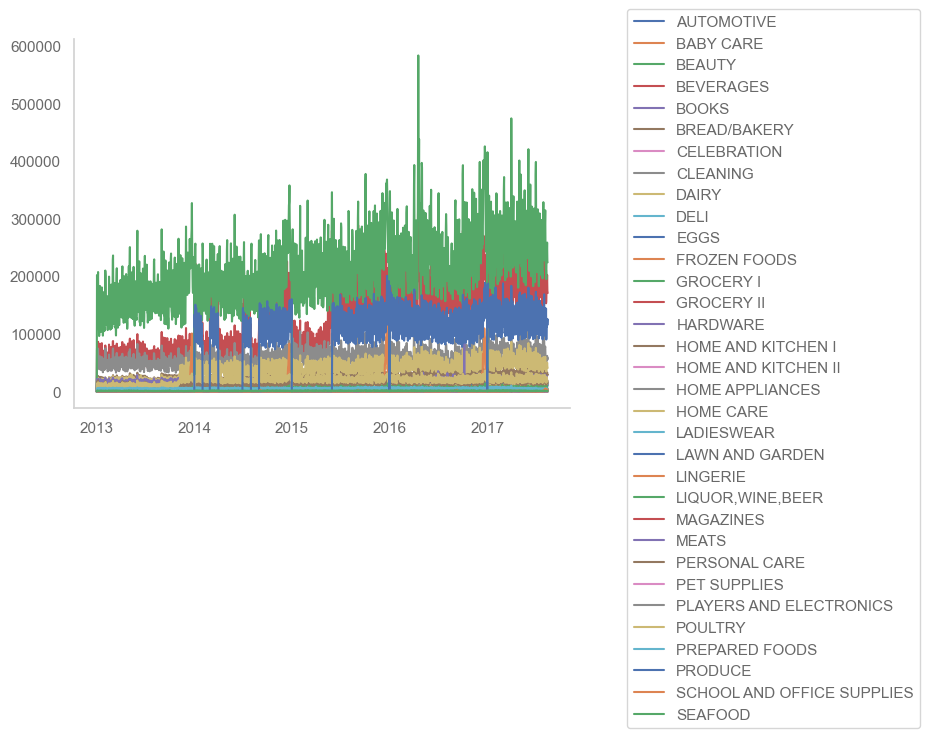

In [145]:
plt.plot(total_sales_df)
plt.legend(total_sales_df.columns,bbox_to_anchor=(1.1,1.1),loc='best')
plt.show()

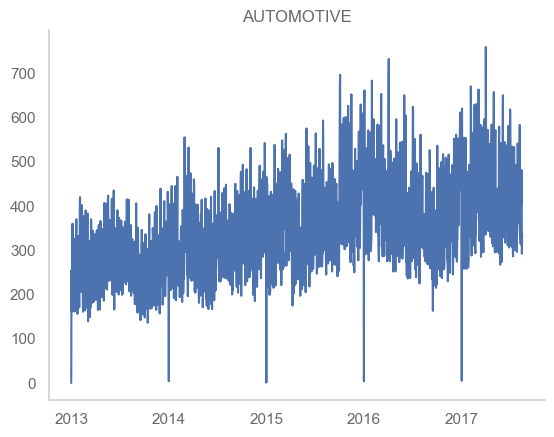

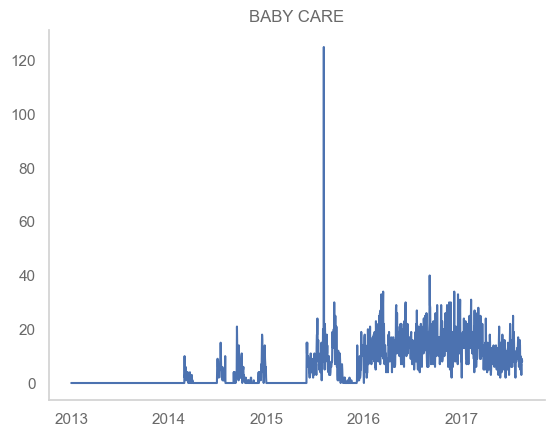

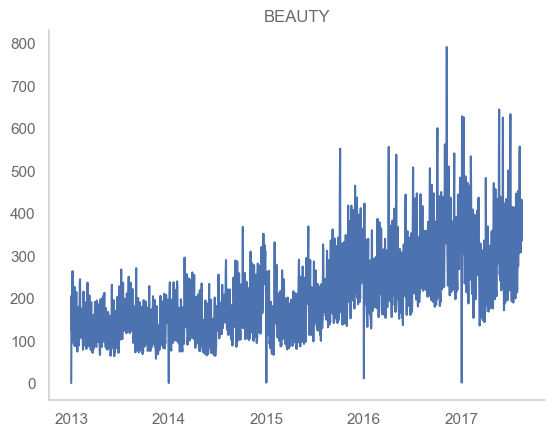

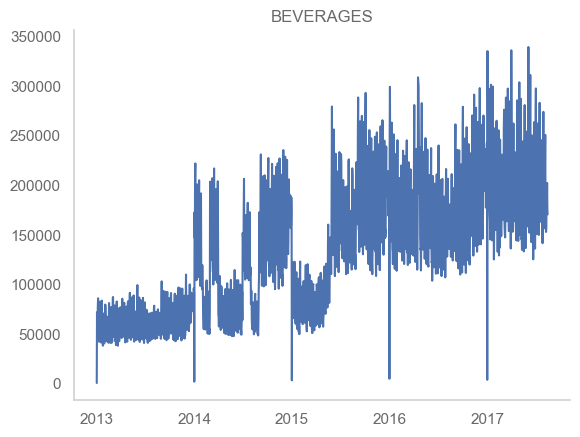

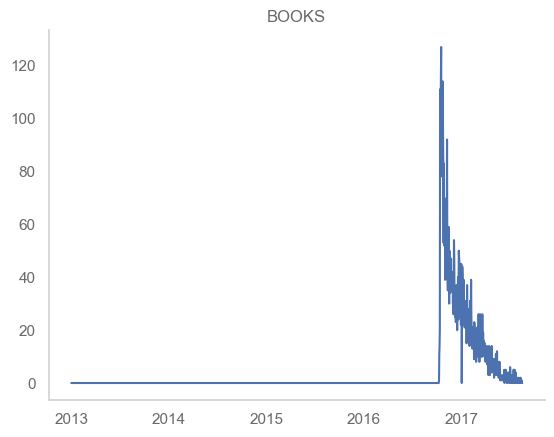

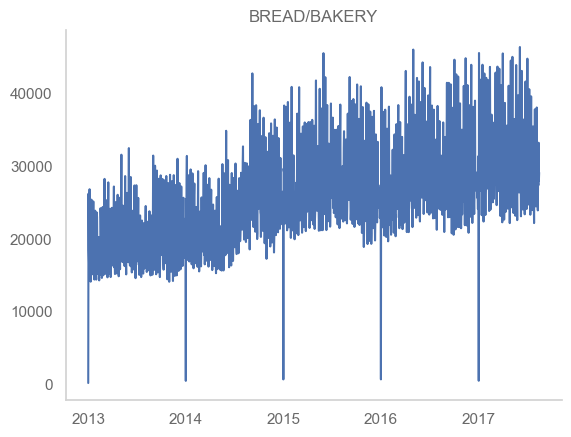

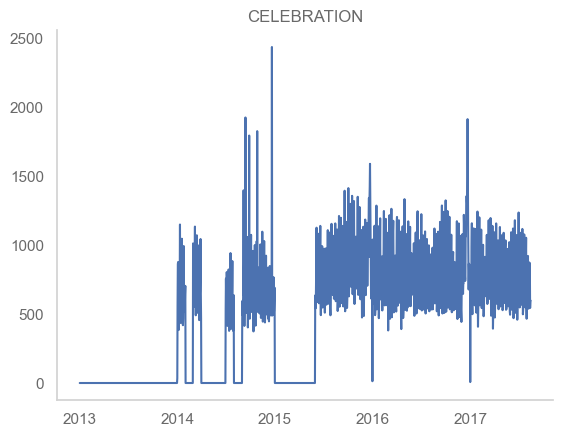

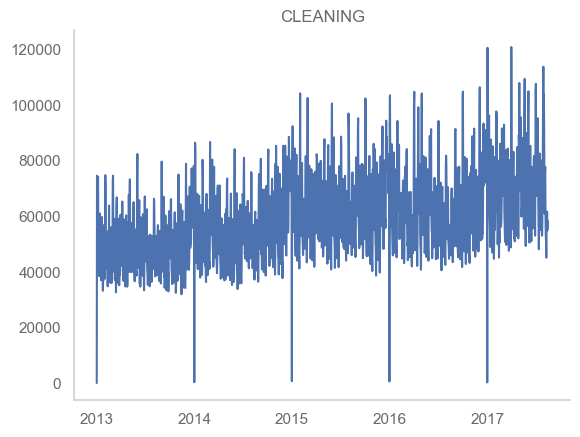

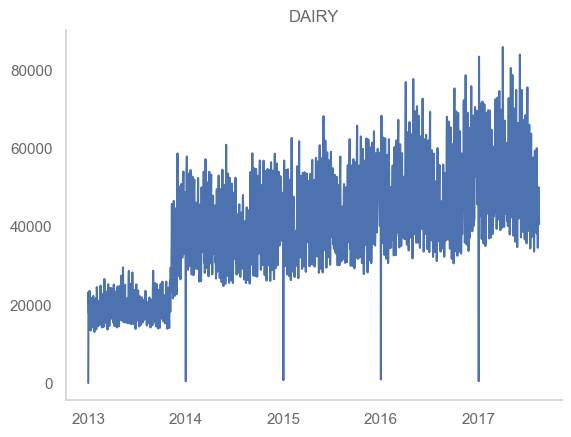

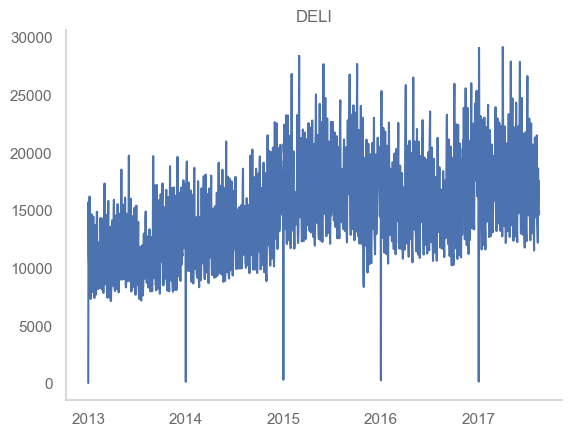

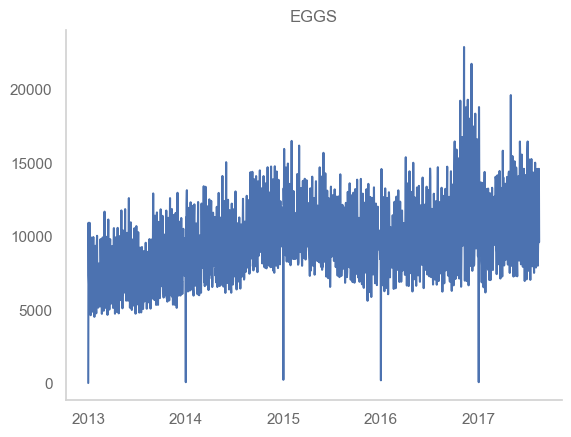

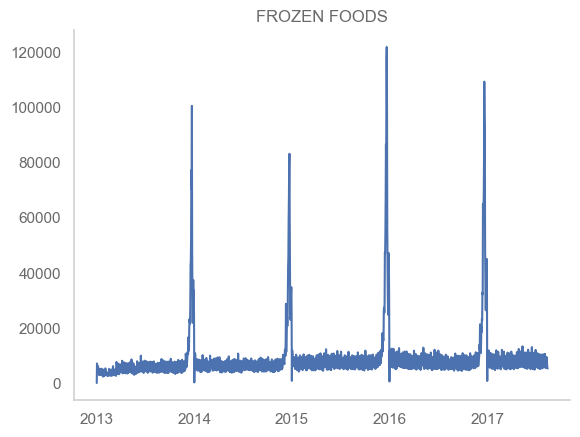

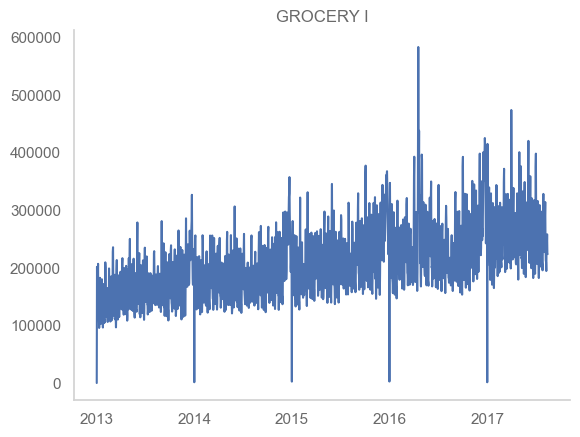

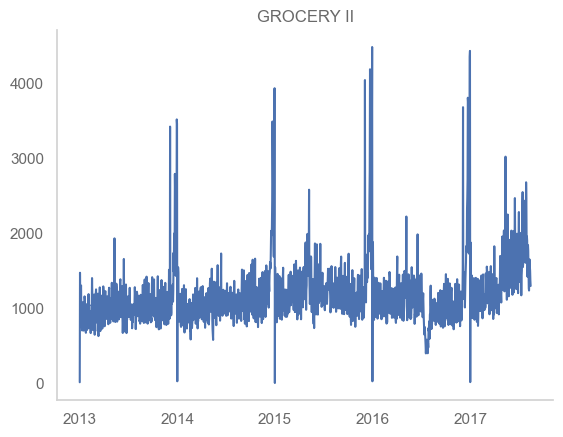

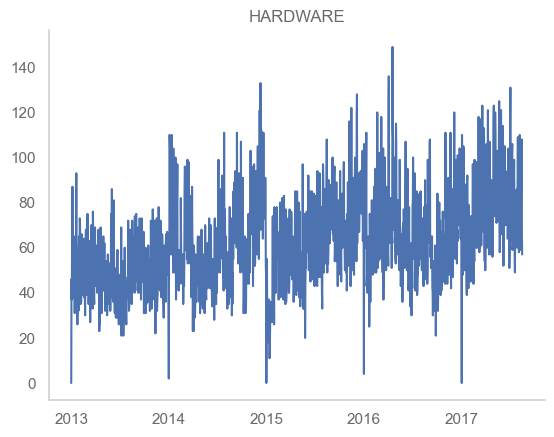

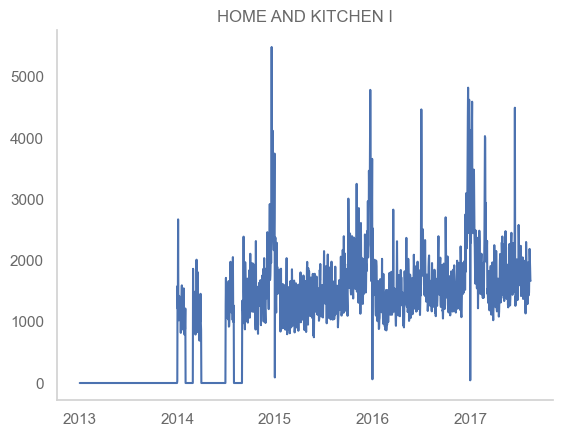

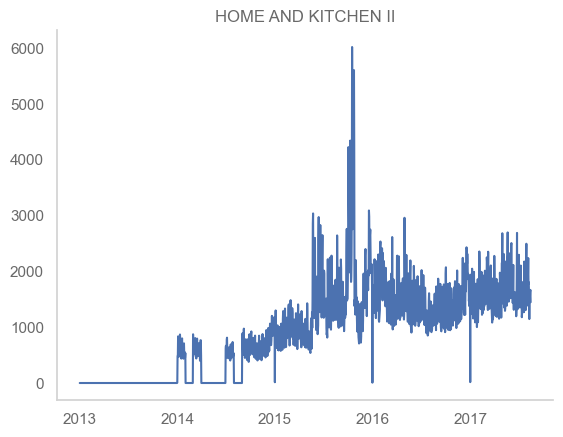

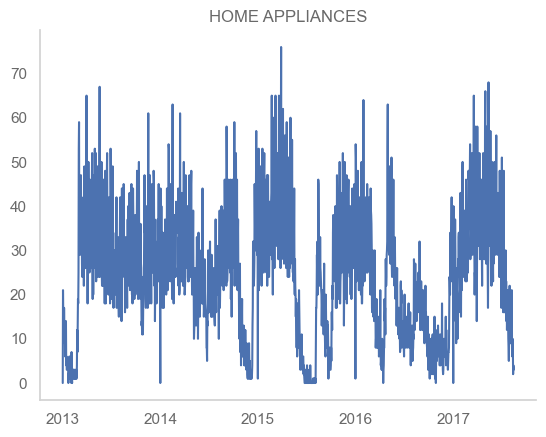

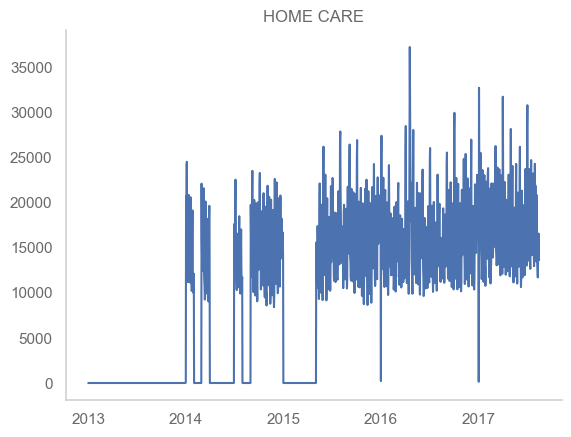

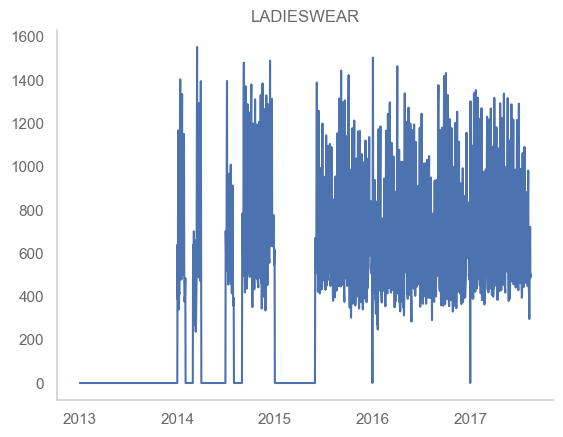

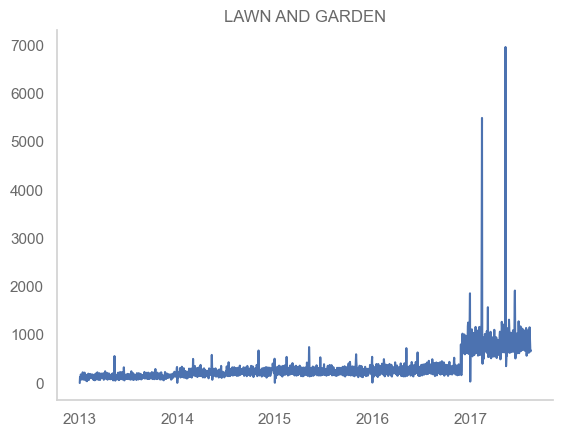

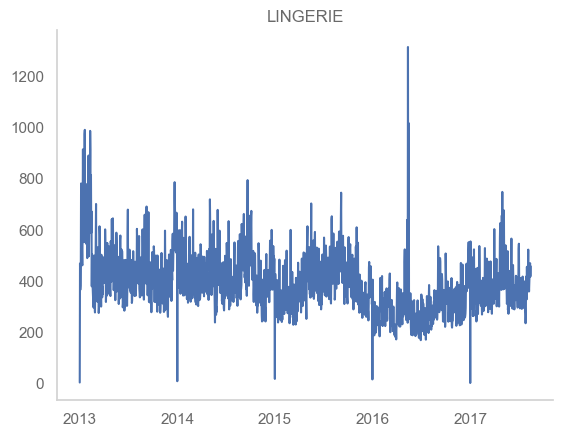

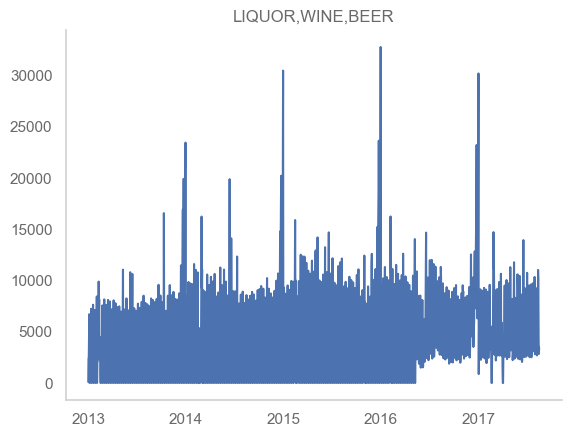

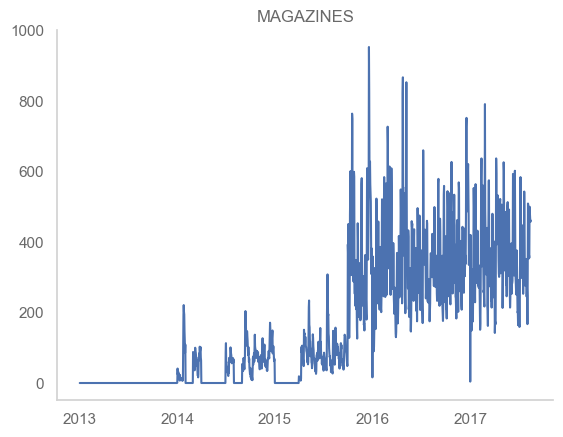

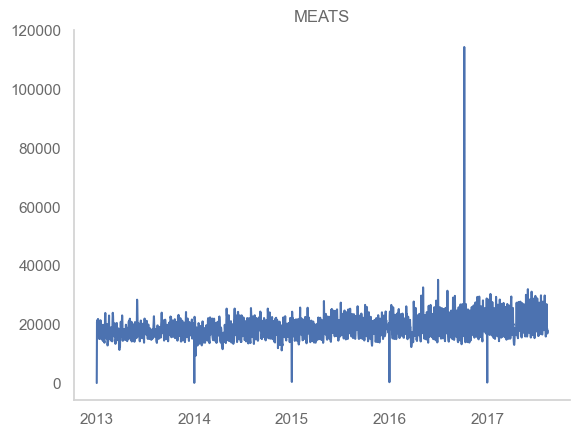

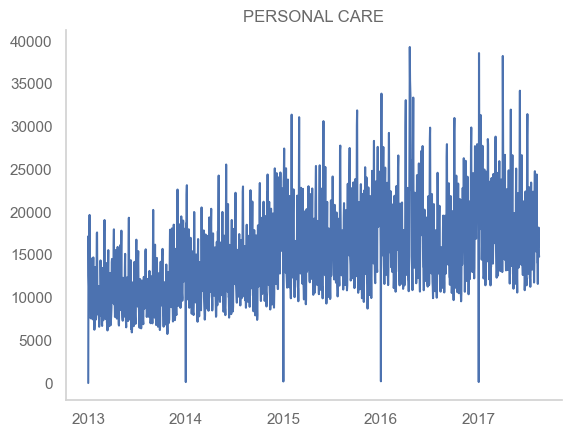

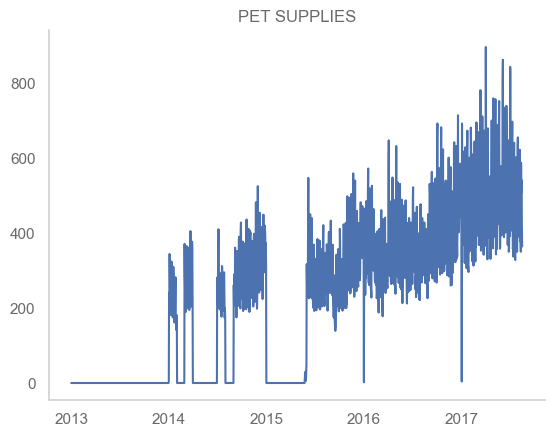

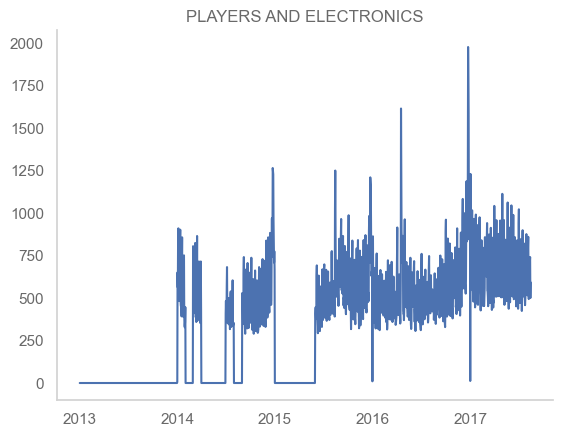

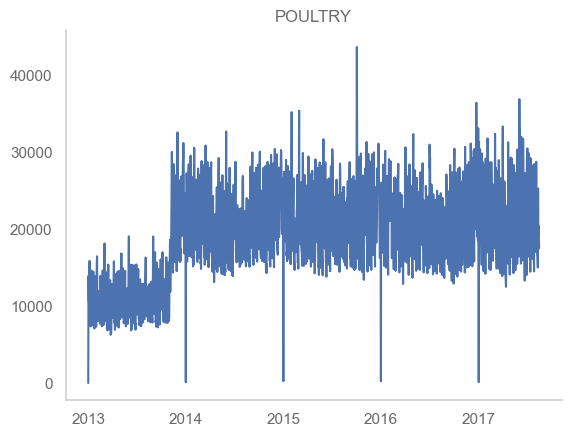

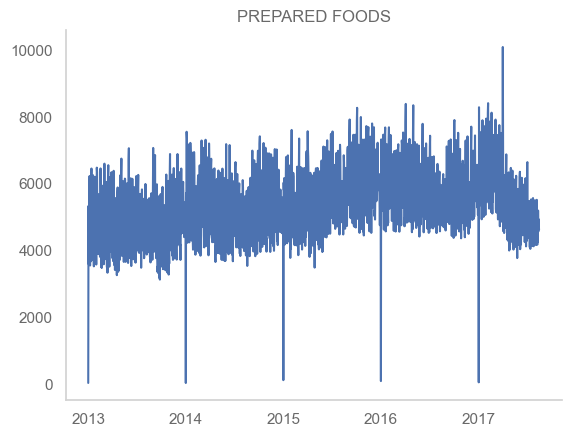

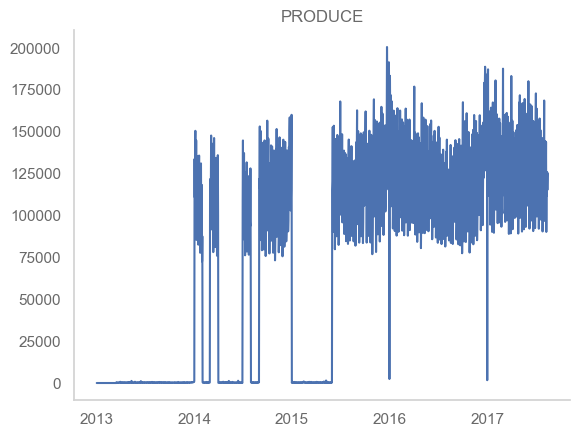

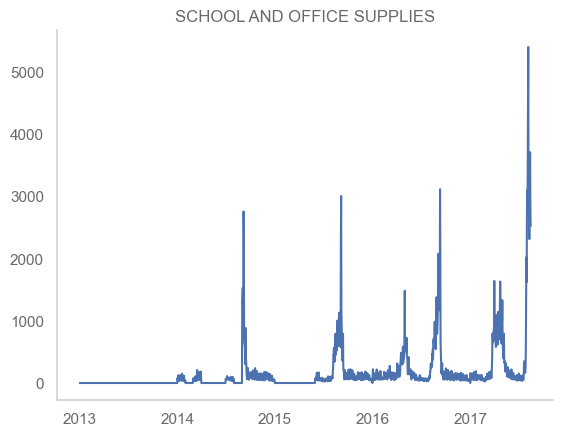

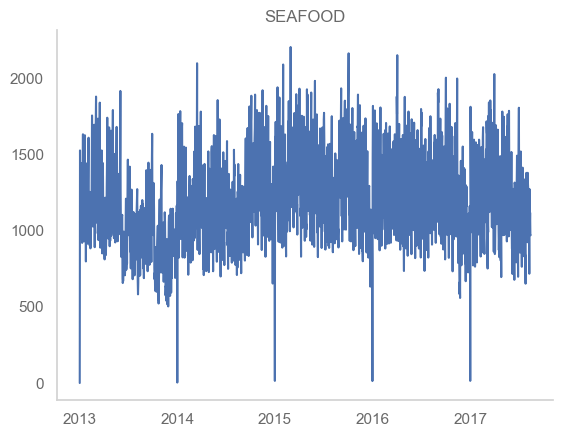

In [146]:
# plotting data for each family to see the distribution and to identify any trends
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.title(column)
    plt.show()

We see that the data for the year 2013 and 2014 is completely missing or very sparse for product family like Books, Baby Care, Celebration, Home and Kitchen, School and Office Supply etc. and since we have data till aug 2017, lets take the recent 2 years worth of data from Aug 2015 to Aug 2017 as this will capture any seasonal trends too

In [149]:
total_sales_df = total_sales_df[total_sales_df.index >= '2015-08-15']

In [152]:
total_sales_df.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-08-15,454.00,18.00,251.00,217135.00,0.00,32509.91,1157.00,75837.00,48578.00,19946.92,11232.00,10075.02,280491.48,1552.00,108.00,1899.00,1526.00,46.00,18924.00,879.00,268.00,525.00,9423.00,153.00,20403.94,19398.00,370.00,1250.00,24718.80,6854.54,128147.18,701.00,1507.24
2015-08-16,413.00,11.00,313.00,208213.00,0.00,34851.88,724.00,75824.00,50930.00,21178.46,11977.00,7526.03,266657.28,1441.00,62.00,1418.00,1850.00,45.00,19757.00,955.00,220.00,530.00,0.00,157.00,20616.16,21048.00,359.00,913.00,25480.78,6640.39,131493.93,793.00,1448.72
2015-08-17,289.00,14.00,175.00,149741.00,0.00,26361.77,593.00,59718.00,38358.00,15755.02,10713.00,5145.30,205150.61,1161.00,49.00,1143.00,1343.00,36.00,14120.00,564.00,154.00,480.00,2968.00,125.00,16725.03,14854.00,263.00,593.00,18549.11,5212.50,102769.60,458.00,1166.22
2015-08-18,295.00,10.00,166.00,132609.00,0.00,23915.95,709.00,52749.00,33273.00,14119.25,8123.00,5050.99,181016.01,955.00,69.00,1181.00,1320.00,31.00,12202.00,485.00,187.00,376.00,2984.00,102.00,15377.12,13064.00,193.00,519.00,15722.33,4758.13,106468.23,494.00,951.63
2015-08-19,314.00,5.00,176.00,131368.00,0.00,23995.15,599.00,51157.00,35760.00,13250.04,8001.00,5372.18,178550.63,1011.00,55.00,1132.00,1249.00,27.00,12042.00,492.00,264.00,371.00,3786.00,102.00,15654.35,12581.00,257.00,535.00,16360.62,5275.08,132449.58,545.00,996.73


In [147]:
missing_data(total_sales_df)

,Total,Percent,Types
family,,,
AUTOMOTIVE,0,0.00,float64
BABY CARE,0,0.00,float64
BEAUTY,0,0.00,float64
BEVERAGES,0,0.00,float64
BOOKS,0,0.00,float64
BREAD/BAKERY,0,0.00,float64
CELEBRATION,0,0.00,float64
CLEANING,0,0.00,float64
DAIRY,0,0.00,float64


Lets group the data by different categoroes. The higher the volume of the data the better for forecasting since we can forecast past the noise and end up with lower error bars. This will also let us viaualize the forecasts on similar scales so that we can figur eout if timeseries modelling will work for the ctaegories since time series highly depends on the seasonal data of a certain variation 

In [157]:
# Lets calculate the mean 
avg_daily_sales =  total_sales_df.apply(np.mean, axis=0).sort_values()
avg_daily_sales


family
BOOKS                             8.82
BABY CARE                        11.83
HOME APPLIANCES                  23.21
HARDWARE                         70.21
BEAUTY                          273.44
SCHOOL AND OFFICE SUPPLIES      315.06
MAGAZINES                       328.69
LINGERIE                        343.78
PET SUPPLIES                    381.50
AUTOMOTIVE                      383.20
LAWN AND GARDEN                 491.47
PLAYERS AND ELECTRONICS         576.36
LADIESWEAR                      626.31
CELEBRATION                     770.87
SEAFOOD                        1241.14
GROCERY II                     1246.87
HOME AND KITCHEN II            1560.60
HOME AND KITCHEN I             1707.09
LIQUOR,WINE,BEER               5157.08
PREPARED FOODS                 5643.84
FROZEN FOODS                   9828.31
EGGS                          10069.28
HOME CARE                     15734.36
DELI                          16222.12
PERSONAL CARE                 17091.29
MEATS             

In [156]:
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(),[33,66])

In [64]:
low_vol_columns = avg_daily_sales[avg_daily_sales<=low].index
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>mid].index

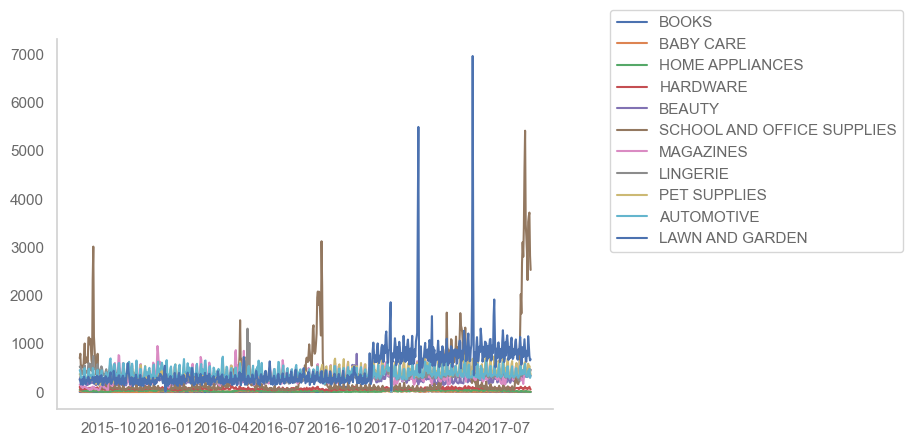

In [70]:
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns,loc='best', bbox_to_anchor=(1.1,1.1))
plt.show()

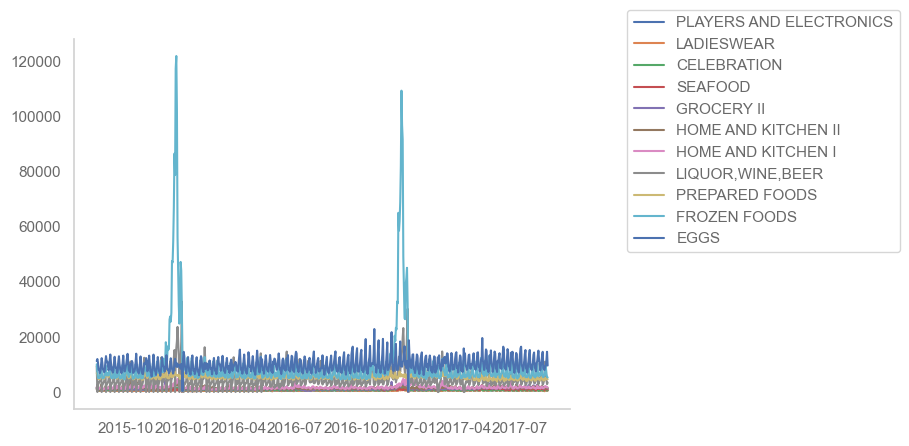

In [72]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns,loc='best', bbox_to_anchor=(1.1,1.1))
plt.show()

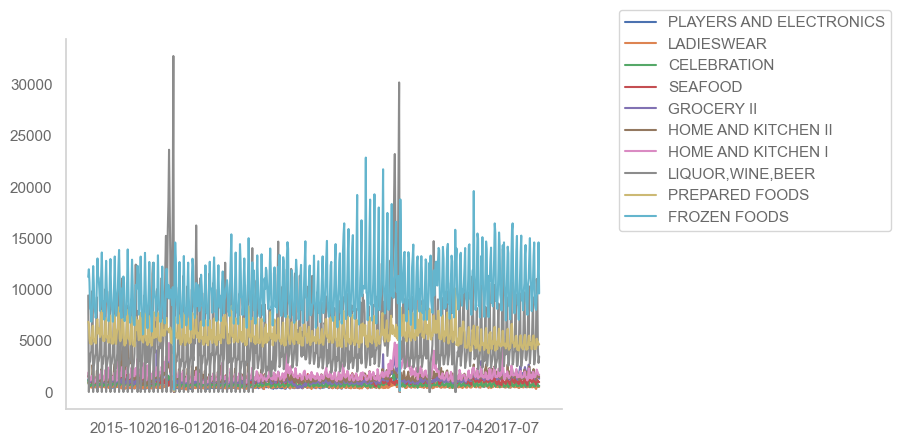

In [75]:
plt.plot(total_sales_df[mid_vol_columns].drop(columns='FROZEN FOODS'))
plt.legend(mid_vol_columns,loc='best', bbox_to_anchor=(1.1,1.1))
plt.show()

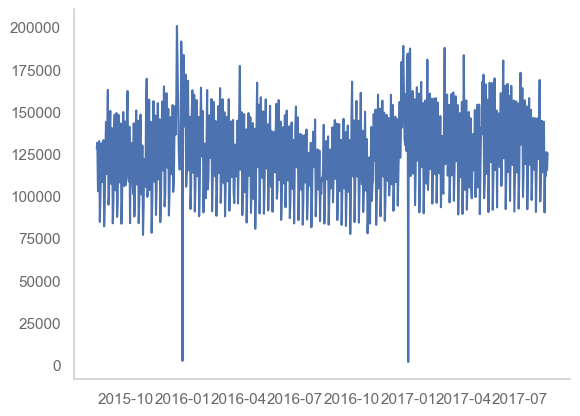

In [76]:
plt.plot(total_sales_df['PRODUCE'])
plt.legend(mid_vol_columns)

In [77]:
total_sales_df.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-08-15,454.00,18.00,251.00,217135.00,0.00,32509.91,1157.00,75837.00,48578.00,19946.92,11232.00,10075.02,280491.48,1552.00,108.00,1899.00,1526.00,46.00,18924.00,879.00,268.00,525.00,9423.00,153.00,20403.94,19398.00,370.00,1250.00,24718.80,6854.54,128147.18,701.00,1507.24
2015-08-16,413.00,11.00,313.00,208213.00,0.00,34851.88,724.00,75824.00,50930.00,21178.46,11977.00,7526.03,266657.28,1441.00,62.00,1418.00,1850.00,45.00,19757.00,955.00,220.00,530.00,0.00,157.00,20616.16,21048.00,359.00,913.00,25480.78,6640.39,131493.93,793.00,1448.72
2015-08-17,289.00,14.00,175.00,149741.00,0.00,26361.77,593.00,59718.00,38358.00,15755.02,10713.00,5145.30,205150.61,1161.00,49.00,1143.00,1343.00,36.00,14120.00,564.00,154.00,480.00,2968.00,125.00,16725.03,14854.00,263.00,593.00,18549.11,5212.50,102769.60,458.00,1166.22
2015-08-18,295.00,10.00,166.00,132609.00,0.00,23915.95,709.00,52749.00,33273.00,14119.25,8123.00,5050.99,181016.01,955.00,69.00,1181.00,1320.00,31.00,12202.00,485.00,187.00,376.00,2984.00,102.00,15377.12,13064.00,193.00,519.00,15722.33,4758.13,106468.23,494.00,951.63
2015-08-19,314.00,5.00,176.00,131368.00,0.00,23995.15,599.00,51157.00,35760.00,13250.04,8001.00,5372.18,178550.63,1011.00,55.00,1132.00,1249.00,27.00,12042.00,492.00,264.00,371.00,3786.00,102.00,15654.35,12581.00,257.00,535.00,16360.62,5275.08,132449.58,545.00,996.73


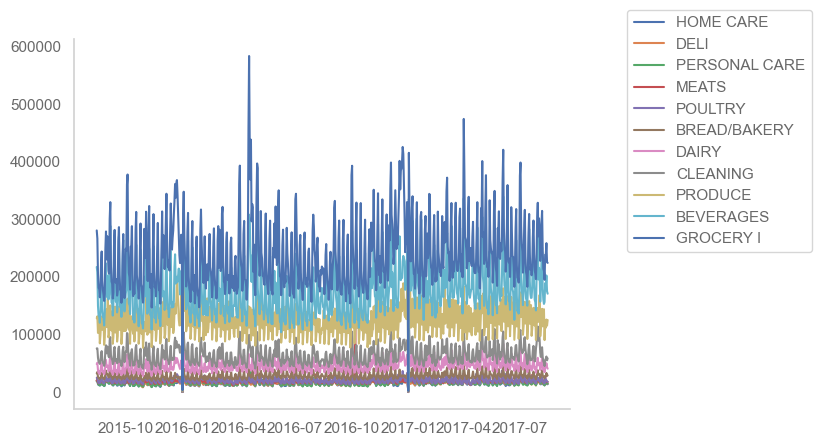

In [74]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns,loc='best', bbox_to_anchor=(1.1,1.1))
plt.show()

In [78]:
# Test with a single product -- Produce

In [79]:
feature = "PRODUCE"
prediction_days = 30

In [80]:
df = total_sales_df[[feature]].reset_index()

In [81]:
df.head()

family,date,PRODUCE
0,2015-08-15,128147.18
1,2015-08-16,131493.93
2,2015-08-17,102769.60
3,2015-08-18,106468.23
4,2015-08-19,132449.58


In [86]:
# adding holiday data
# we will having a 4 day period like 2 days prior and 1 day after the holiday
holiday = pd.DataFrame()

# ecuador_holidays = holidays.EC()
# ecuador_holidays = holidays.country_holidays('EC')


for date,name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday,pd.DataFrame({'ds':date,'holiday':"EC-holidays","lower_window":-2,"upper_window":1},index=[0])], ignore_index=True)
    
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

,ds,holiday,lower_window,upper_window
0,2015-01-01,EC-holidays,-2,1
1,2015-02-16,EC-holidays,-2,1
2,2015-02-17,EC-holidays,-2,1
3,2015-04-03,EC-holidays,-2,1
4,2015-05-01,EC-holidays,-2,1


In [93]:
# Variables
# we are setting the forecast date as 2017-07-01, post this date data will be used to test the performance of 
#our model, the training data will be from Aug 2015 - Jun 2017

forecast_start_dt = pd.to_datetime("2017-07-01")
forecast_start_dt = (forecast_start_dt).strftime("%Y-%m-%d")
print(forecast_start_dt)

2017-07-01


In [96]:
#Prophet Model

df_copy = df.copy()
#prophet requires the date column to be renamed as ds and the target column to be renamed as y
df_copy = df_copy.rename(columns={'date':'ds',feature:'y'})

In [98]:
# confirming it to be a numeric col
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

# confirming it to be a datetime col
df_copy['ds'] = pd.to_datetime(df_copy['ds'])

# creating a train set as per our forecast date
train_set = df_copy[(df_copy['ds'] < forecast_start_dt)]


m = Prophet()
m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)


# adding filter to add only the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_dt
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

12:39:30 - cmdstanpy - INFO - Chain [1] start processing
12:39:31 - cmdstanpy - INFO - Chain [1] done processing


In [99]:
predicted_df.head()

,ds,yhat
684,2017-07-01,144612.13
685,2017-07-02,155336.04
686,2017-07-03,122383.38
687,2017-07-04,127642.39
688,2017-07-05,160253.27


In [158]:
predicted_df.tail()

,ds,yhat,ytrue
25,2017-07-26,158081.61,145917.92
26,2017-07-27,100458.47,90481.29
27,2017-07-28,113803.55,111948.89
28,2017-07-29,142606.86,131988.66
29,2017-07-30,153321.65,146045.80


In [101]:
df_copy = df.copy()
df_copy.columns= ['ds','ytrue']
predicted_df = predicted_df.merge(df_copy)

In [102]:
predicted_df

,ds,yhat,ytrue
0,2017-07-01,144612.13,155487.63
1,2017-07-02,155336.04,172890.14
2,2017-07-03,122383.38,130389.20
3,2017-07-04,127642.39,131534.55
4,2017-07-05,160253.27,163804.33
5,2017-07-06,102667.68,99395.60
6,2017-07-07,116017.82,114346.57
7,2017-07-08,144864.32,139294.77
8,2017-07-09,155588.23,156633.92
9,2017-07-10,122635.58,118856.99


In [103]:
mape(predicted_df.ytrue,predicted_df.yhat)

6.263881123154167

### Cross Validation with Prophet

Find the best parameters by testing over various periods of time with those parameters (cross-validation)

In [162]:
# we are cross validating the data to get predictions on different sets and aggregate that\
# here we are giving initial 365 dyas of data and period of 30 days to predict, we are giving a window of 
#30 days and this will essentially increasie the training time by 30 days one at a time and predict on the next 30 days
# it will keep doing this untill the max date

m = Prophet()
m.fit(train_set)
df_cv = cross_validation(m, initial='365 days', period ='30 days', horizon='30 days')

15:30:13 - cmdstanpy - INFO - Chain [1] start processing
15:30:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/10 [00:00<?, ?it/s]

15:30:13 - cmdstanpy - INFO - Chain [1] start processing
15:30:13 - cmdstanpy - INFO - Chain [1] done processing
15:30:13 - cmdstanpy - INFO - Chain [1] start processing
15:30:13 - cmdstanpy - INFO - Chain [1] done processing
15:30:13 - cmdstanpy - INFO - Chain [1] start processing
15:30:13 - cmdstanpy - INFO - Chain [1] done processing
15:30:13 - cmdstanpy - INFO - Chain [1] start processing
15:30:14 - cmdstanpy - INFO - Chain [1] done processing
15:30:14 - cmdstanpy - INFO - Chain [1] start processing
15:30:14 - cmdstanpy - INFO - Chain [1] done processing
15:30:14 - cmdstanpy - INFO - Chain [1] start processing
15:30:14 - cmdstanpy - INFO - Chain [1] done processing
15:30:14 - cmdstanpy - INFO - Chain [1] start processing
15:30:14 - cmdstanpy - INFO - Chain [1] done processing
15:30:14 - cmdstanpy - INFO - Chain [1] start processing
15:30:14 - cmdstanpy - INFO - Chain [1] done processing
15:30:14 - cmdstanpy - INFO - Chain [1] start processing
15:30:14 - cmdstanpy - INFO - Chain [1]

In [161]:
train_set['ds'].min(), train_set['ds'].max()

(Timestamp('2015-08-15 00:00:00'), Timestamp('2017-06-30 00:00:00'))

In [163]:
# mape here gives the mean absolute percentage error which looks really good, like 9% error, 8% error and so on
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,411911254.07,20295.60,13088.62,0.09,0.07,0.10,0.80
1,4 days,269732789.34,16423.54,11119.74,0.08,0.06,0.08,0.80
2,5 days,141547986.52,11897.39,8894.95,0.07,0.06,0.07,0.87
3,6 days,126310847.91,11238.81,9216.62,0.07,0.07,0.07,0.87
4,7 days,95815198.40,9788.52,8407.64,0.07,0.07,0.07,0.93


In [109]:
# however the mape for the last day is very high -- 300%, we need to look into this
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
23,26 days,254632370.78,15957.20,12018.61,0.10,0.08,0.10,0.83
24,27 days,305198598.48,17469.93,13245.62,0.11,0.09,0.11,0.80
25,28 days,502076648.26,22407.07,15686.99,0.13,0.08,0.13,0.77
26,29 days,549411933.51,23439.54,16593.94,0.12,0.09,0.13,0.66
27,30 days,1247042864.57,35313.49,21490.91,3.01,0.12,0.19,0.63


df_p gives the overall MAPE, but if we want to get more granularand calculate daily differences using mape metric, we can do as below. This will allow to detect issues in predicting certain time periods, which are inherent issues in the data which may or may not be fixable. 


In [164]:
df_cv['mape'] = (df_cv['y']-df_cv['yhat']) / df_cv['y'] * 100
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y']

df_cv.sort_values('mape', ascending=False).head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
110,2016-12-23,98435.33,83384.99,113802.73,176327.97,2016-12-02,44.17,False
116,2016-12-30,98482.55,83292.78,115001.08,175022.19,2016-12-02,43.73,False
109,2016-12-22,87944.49,71718.44,103462.99,140444.94,2016-12-02,37.38,False
119,2017-01-02,117105.88,99094.29,136568.26,184113.03,2017-01-01,36.39,False
120,2017-01-03,121366.40,101809.01,140362.68,183306.23,2017-01-01,33.79,False
111,2016-12-24,127831.67,113002.66,143776.69,188809.16,2016-12-02,32.30,False
117,2016-12-31,127878.90,111684.13,143155.93,184154.67,2016-12-02,30.56,False
115,2016-12-29,87991.72,71436.70,103997.72,126652.84,2016-12-02,30.53,False
238,2017-05-01,126201.34,105385.22,146268.01,167558.58,2017-04-01,24.68,False
108,2016-12-21,143735.72,128309.19,159588.93,179251.71,2016-12-02,19.81,False


The granular mape helps us to identify the reason why the mape is higher, because we see a trnd that the mape is higher around the year end. In addition the under predicting the model has higher mape for that time period.
Lets check at the input data here


(array([16709., 16801., 16892., 16983., 17075., 17167., 17257., 17348.]),
 [Text(16709.0, 0, '2015-10'),
  Text(16801.0, 0, '2016-01'),
  Text(16892.0, 0, '2016-04'),
  Text(16983.0, 0, '2016-07'),
  Text(17075.0, 0, '2016-10'),
  Text(17167.0, 0, '2017-01'),
  Text(17257.0, 0, '2017-04'),
  Text(17348.0, 0, '2017-07')])

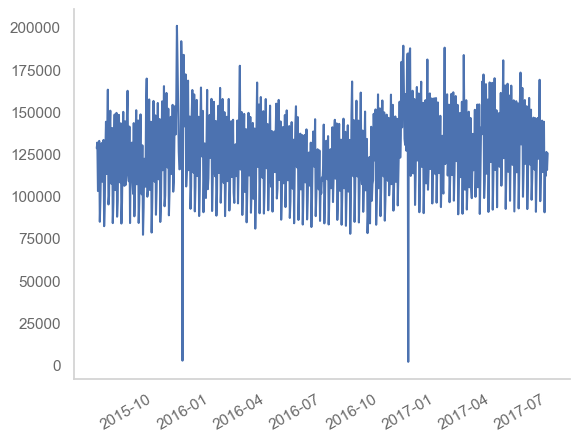

In [166]:
plt.plot(total_sales_df['PRODUCE'])
plt.xticks(rotation =30)

from the plot above its seen that the data for january is off, this is like a systematic error in the data. Its a data issue and this should be normalized

In [111]:
# the model is highly underpredicting for 
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
0,2016-09-04,137051.97,119592.39,153806.82,144954.39,2016-09-03,5.45,False
1,2016-09-05,103702.40,87669.79,121574.72,110104.68,2016-09-03,5.81,False
2,2016-09-06,107795.45,91176.72,125873.79,115898.16,2016-09-03,6.99,False
3,2016-09-07,140075.90,123736.33,156029.18,142809.15,2016-09-03,1.91,False
4,2016-09-08,84285.75,66463.98,100462.31,85680.68,2016-09-03,1.63,False
5,2016-09-09,93707.67,77548.37,110794.14,96152.02,2016-09-03,2.54,False
6,2016-09-10,123851.91,107970.74,140657.43,128750.47,2016-09-03,3.80,False
7,2016-09-11,136600.82,120148.81,153309.91,142536.23,2016-09-03,4.16,False
8,2016-09-12,103251.24,84567.83,118883.45,102988.54,2016-09-03,-0.26,True
9,2016-09-13,107344.29,90104.07,123436.49,104210.54,2016-09-03,-3.01,True


Optimizing fpor Produce feature--- hyperparameter tuning

In [112]:
param_grid = {
    'changepoint_prior_scale':[0.001,0.01,0.1, 0.5],
     'seasonality_prior_scale': [0.01,0.1,1.0,10.0]
}


# Generate all combinations of parameters

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

# use cross validation to evaluate all paramaeters
for params in all_params:
    m = Prophet(**params).fit(train_set) #fit model with given params
    df_cv = cross_validation(m, initial='365 days', period='30 days',horizon='30 days', parallel ='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    

#Find the best parametr
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

    
    

14:33:28 - cmdstanpy - INFO - Chain [1] start processing
14:33:28 - cmdstanpy - INFO - Chain [1] done processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing
14:33:31 - cmdstanpy - INFO - Chain [1] done processing
14:33:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:33:31 - cmdstanpy - INFO - Chain [1] done processing
14:33:31 - cmdstanpy - INFO - Chain [1] done proc

14:33:40 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:44 - cmdstanpy - INFO - Chain [1] start processing
14:33:44 - cmdstanpy - INFO - Chain [1] start processing
14:33:44 - cmdstanpy - INFO - Chain [1] start processing
14:33:44 - cmdstanpy - INFO - Chain [1] done processing
14:33:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:33:44 - cmdstanpy - INFO - Chain [1] start processing
14:33:44 - cmdstanpy - INFO - Chain [1] done processing
14:33:44 - cmdstanpy - ERROR - Chain [1] error: error d

14:34:00 - cmdstanpy - INFO - Chain [1] done processing
14:34:02 - cmdstanpy - INFO - Chain [1] start processing
14:34:02 - cmdstanpy - INFO - Chain [1] start processing
14:34:02 - cmdstanpy - INFO - Chain [1] done processing
14:34:02 - cmdstanpy - INFO - Chain [1] start processing
14:34:02 - cmdstanpy - INFO - Chain [1] done processing
14:34:02 - cmdstanpy - INFO - Chain [1] start processing
14:34:02 - cmdstanpy - INFO - Chain [1] start processing
14:34:02 - cmdstanpy - INFO - Chain [1] start processing
14:34:02 - cmdstanpy - INFO - Chain [1] done processing
14:34:02 - cmdstanpy - INFO - Chain [1] done processing
14:34:02 - cmdstanpy - INFO - Chain [1] start processing
14:34:02 - cmdstanpy - INFO - Chain [1] start processing
14:34:02 - cmdstanpy - INFO - Chain [1] done processing
14:34:02 - cmdstanpy - INFO - Chain [1] start processing
14:34:02 - cmdstanpy - INFO - Chain [1] done processing
14:34:02 - cmdstanpy - INFO - Chain [1] done processing
14:34:02 - cmdstanpy - INFO - Chain [1]

14:34:23 - cmdstanpy - INFO - Chain [1] done processing
14:34:23 - cmdstanpy - INFO - Chain [1] start processing
14:34:24 - cmdstanpy - INFO - Chain [1] done processing
14:34:26 - cmdstanpy - INFO - Chain [1] start processing
14:34:26 - cmdstanpy - INFO - Chain [1] start processing
14:34:26 - cmdstanpy - INFO - Chain [1] start processing
14:34:26 - cmdstanpy - INFO - Chain [1] start processing
14:34:26 - cmdstanpy - INFO - Chain [1] done processing
14:34:26 - cmdstanpy - INFO - Chain [1] start processing
14:34:26 - cmdstanpy - INFO - Chain [1] start processing
14:34:26 - cmdstanpy - INFO - Chain [1] start processing
14:34:26 - cmdstanpy - INFO - Chain [1] done processing
14:34:26 - cmdstanpy - INFO - Chain [1] done processing
14:34:26 - cmdstanpy - INFO - Chain [1] start processing
14:34:26 - cmdstanpy - INFO - Chain [1] done processing
14:34:26 - cmdstanpy - INFO - Chain [1] done processing
14:34:26 - cmdstanpy - INFO - Chain [1] start processing
14:34:26 - cmdstanpy - INFO - Chain [1

In [115]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale     rmse
0                      0.00                     0.01 18782.74
1                      0.00                     0.10 18893.21
2                      0.00                     1.00 18530.96
3                      0.00                    10.00 18650.23
4                      0.01                     0.01 18185.61
5                      0.01                     0.10 17779.54
6                      0.01                     1.00 17756.78
7                      0.01                    10.00 17722.73
8                      0.10                     0.01 18096.29
9                      0.10                     0.10 17727.24
10                     0.10                     1.00 17714.22
11                     0.10                    10.00 17712.65
12                     0.50                     0.01 18098.10
13                     0.50                     0.10 17752.96
14                     0.50                     1.00 17759.66
15      

In [114]:
tuning_results.sort_values('rmse')

,changepoint_prior_scale,seasonality_prior_scale,rmse
11,0.10,10.00,17712.65
10,0.10,1.00,17714.22
7,0.01,10.00,17722.73
9,0.10,0.10,17727.24
13,0.50,0.10,17752.96
6,0.01,1.00,17756.78
14,0.50,1.00,17759.66
15,0.50,10.00,17772.76
5,0.01,0.10,17779.54
8,0.10,0.01,18096.29


In [116]:
tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0]

changepoint_prior_scale       0.10
seasonality_prior_scale      10.00
rmse                      17712.65
Name: 0, dtype: float64

In [117]:
dict(tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0])

{'changepoint_prior_scale': 0.1,
 'seasonality_prior_scale': 10.0,
 'rmse': 17712.650331539604}

In [121]:
params_dictionary = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse',axis='columns').iloc[0])

m = Prophet(changepoint_prior_scale = params_dictionary['changepoint_prior_scale'], 
            seasonality_prior_scale = params_dictionary['seasonality_prior_scale'])


In [122]:
# building the model again with the hypertuned params with low rmse
m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_dt 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)
mape(predicted_df['ytrue'], predicted_df['yhat'])

14:36:33 - cmdstanpy - INFO - Chain [1] start processing
14:36:33 - cmdstanpy - INFO - Chain [1] done processing


4.93085652524466